<a href="https://colab.research.google.com/github/Depersonalizc/AL-cancer-detection/blob/main/Training_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC4080 Midterm Project
## 📝Active Learning for Label-Efficient Histopathologic Cancer Detection


*Group 24* 

- 🐷 CHEN Ang   (118010009)

- 🐸 FU Quanzhi (118010070)

## Prepare data

In [4]:
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1gAMjcaut2C3cbWoke8R4vWFQkfoCQX_x
!unzip -q hist_cancer_det.zip -d ./data/
print('Done!')

Downloading...
From: https://drive.google.com/uc?id=1gAMjcaut2C3cbWoke8R4vWFQkfoCQX_x
To: /content/hist_cancer_det.zip
100% 243M/243M [00:01<00:00, 213MB/s]
replace ./data/labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Done!


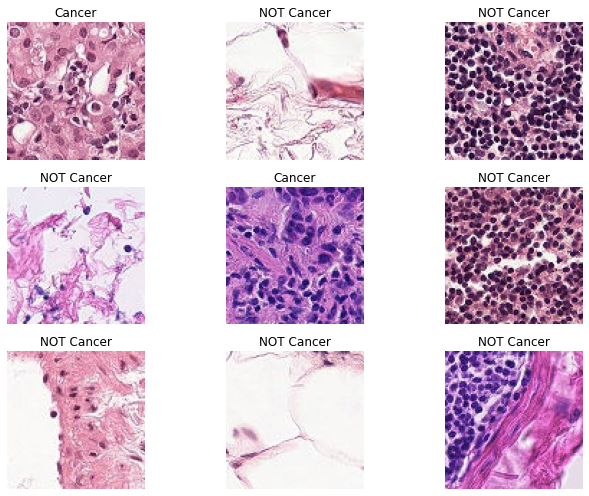

In [9]:
# @title Show first few samples of the dataset

%matplotlib inline
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np

df = pd.read_csv("./data/labels.csv")
fig = plt.figure(figsize=(10, 7))
for i in range(9):
    fig.add_subplot(3, 3, i+1)
    fname = f"./data/images/{df.id[i]}.tif"
    plt.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
    plt.title(('' if df.label[i] else 'NOT ') + 'Cancer')
    plt.axis("off")
fig.tight_layout()

In [10]:
# @title `Dataset` w/ efficient loading utils

from concurrent import futures
from functools import partial
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset


def pmap(f, iterable, max_threads=None, show_pbar=False, **kwargs):
    """Concurrent version of map()."""
    with futures.ThreadPoolExecutor(max_threads) as executor:
      if show_pbar:
        results = tqdm(executor.map(f, iterable, **kwargs))
      else:
        results = executor.map(f, iterable, **kwargs)
      return list(results)


class HistopathologicDataset(Dataset):
    def __init__(self, df, datadir, transform=None, return_idx=False):
        fnames = [f"{datadir}/{i}.tif" for i in df.id]
        labels = df.label.tolist()

        def get_xy(idx):
            x = cv2.imread(fnames[idx])
            y = labels[idx]
            return x, y

        self.items = pmap(get_xy, range(len(df)), show_pbar=True)
        self.transform = transform
        self.return_idx = return_idx

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img, label = self.items[index]
        if self.transform:
            img = self.transform(img)
        if self.return_idx: return img, label, index
        return img, label

In [19]:
# @title Data preprocessing & augmentation

from torchvision import transforms

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.CenterCrop((49, 49)),
    transforms.ToTensor(),
    normalize,
])

valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((49, 49)),
    transforms.ToTensor(),
    normalize,
])

split = int(0.8 * len(df))  # 2000 held-out validation samples
batch_size = 128
val_batch_size = 1000
valid_dataset = HistopathologicDataset(df[split:], "./data/images", valid_transforms)
valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size)

## Model

In [20]:
# @title ResNet50 w/ a binary classification head

from torch import nn
from torchvision import models

resnet = models.resnet50(pretrained=True)

in_features = resnet.fc.in_features
num_hidden = 512

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features=in_features, out_features=num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(in_features=num_hidden, out_features=2),
)

base_model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)

## Training Utils

In [37]:
# @title Generic train/val loops

from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 1e-3
criterion = nn.CrossEntropyLoss()
imgs_dir = "./data/images"


def train(train_loader, model, criterion, optimizer, scheduler):
    total = len(train_loader.dataset)
    total_loss = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # We use an one-cycle LR schedule - step every iteration
    epoch_loss = total_loss / total
    return epoch_loss


def validate(valid_loader, model, criterion):
    total = len(valid_loader.dataset)
    total_correct = 0
    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:            
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            _, preds = torch.max(logits, 1)
            total_correct += torch.count_nonzero(preds == labels)
            total_loss += loss.item() * images.shape[0]
    epoch_loss = total_loss / total
    epoch_acc = total_correct / total
    return epoch_loss, epoch_acc


def fit(model, num_epochs, train_loader, valid_loader):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = OneCycleLR(optimizer, max_lr=lr*10., epochs=num_epochs, steps_per_epoch=len(train_loader))
    print("epoch\ttrain loss\tvalid loss\taccuracy")
    for epoch in range(num_epochs):
        train_loss = train(train_loader, model, criterion, optimizer, scheduler)
        valid_loss, valid_acc = validate(valid_loader, model, criterion)
        print(f"{epoch}\t{train_loss:.5f}\t\t{valid_loss:.5f}\t\t{valid_acc:.4f}")

In [ ]:
# @title Active learning cycles

def random_cycle(valid_loader, model, batch_size, num_cycle=10, size=50):
    # Random query: Label first (n*size) samples in cycle n
    for n in range(1, num_cycle+1):
        labeled_inds = list(range(n*size))
        labeled_dset = HistopathologicDataset(df.iloc[labeled_inds,:], imgs_dir, train_transforms)
        labeled_dloader = DataLoader(labeled_dset, batch_size=batch_size, shuffle=True)
        print("-"*20, f"{n}th Cycle: {len(labeled_inds)} samples selected", "-"*20)
        fit(model, 20, labeled_dloader, valid_loader)
    fit(model, 50, labeled_dloader, valid_loader)
    return labeled_inds 


def top_conf_cycle(query_loader, valid_loader, model, batch_size, num_cycle=10, size=50):
    labeled_inds = []  # indices of currently labeled samples
    for n in range(1, num_cycle+1):
      model.eval()
      with torch.no_grad():
          # eval on the entire dataset
          all_conf = []
          for images, _ in query_loader:              
              images = images.to(device)
              outputs = model(images)
              prob = nn.functional.softmax(outputs, dim=1)
              conf, _ = prob.max(dim=1)  # top confidence
              all_conf.append(conf)
          all_conf = torch.cat(all_conf)

          # get top-`size` lowest confidences from unlabeled dataset
          unlabeled_inds = set(range(len(all_conf))) - set(labeled_inds)
          unlabeled_inds = list(unlabeled_inds)
          all_conf = all_conf[unlabeled_inds]
          selected_conf, selected_inds = torch.topk(all_conf, size, largest=False)

          # extend the labeled dataset
          labeled_inds += selected_inds.tolist()
          labeled_dset = HistopathologicDataset(df.iloc[labeled_inds, :], imgs_dir, train_transforms)
          labeled_dloader = DataLoader(labeled_dset, batch_size=batch_size, shuffle=True)
          print("-"*20, f"{n}th Cycle: {len(labeled_inds)} labeled samples", "-"*20)

      # train the model on the new labeled dataset
      fit(model, 20, labeled_dloader, valid_loader)
    
    # final train yifa
    fit(model, 50, labeled_dloader, valid_loader)
    
    return labeled_inds 

def mc_dropout_cycle(query_loader, valid_loader, model, fwd_passes=10, num_cycle=10, size=50):
  from collections import defaultdict

  def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

  labeled_inds = []
  for n in range(1, num_cycle+1):
      model.eval()
      enable_dropout(model)
      with torch.no_grad():
          selected_idx = []
          idx_prob = defaultdict(float)
          for images, labels, idx in query_loader:
            preds = []
            for _ in range(fwd_passes):
              images = images.to(device)
              labels = labels.to(device)
              logits = model(images)
              prob = nn.functional.softmax(logits, dim=1)  # (B, C)
              pred = prob.argmax(1, keepdim=True)  # (B, 1)
              preds.append(pred)

            preds = torch.cat(preds, 1)  # (B, fwd_passes)
            p = torch.mean(preds.float(), 1)  # (B, )
            # max the entropy is equivalent to max -|p - 1/2| for binary data
            mc_entropy = - torch.abs(p - 0.5)  # (B, )

            for i in range(len(prob)):
              idx_prob[idx[i]] = mc_entropy[i]

            selected_idx.extend(idx.numpy().tolist())

      selected_idx = set(selected_idx)
      selected_idx = list(selected_idx-set(labeled_inds))
      selected_idx.sort(key=lambda x: idx_prob[x])
      labeled_inds.extend(selected_idx[:size])
      new_dataset = HistopathologicDataset(df.iloc[labeled_inds,:], imgs_dir, train_transforms, return_idx=False)
      new_dataloader = DataLoader(new_dataset, batch_size=batch_size)
      print("-"*20, f"{n}th Cycle: {len(labeled_inds)} samples selected", "-"*20)
      fit(model, 20, new_dataloader, valid_loader)
  fit(model, 50, new_dataloader, valid_loader)

  return labeled_inds 

## Ready...Set...Train!

In [ ]:
# @title Try active learning yourself!

# @markdown Strategy for querying samples to be labelled.
strategy = 'MC dropout'  # @param ['random', 'top confidence', 'MC dropout']
# @markdown Percentage of 8,000 samples to be labelled.
percentage = '1.25%'   # @param ['1.25%', '3%', '6.25%', '10%']

num_cycle, size = {
    '1.25%': (10, 10),
    '3%'   : (20, 12),
    '6.25%': (20, 25),
    '10%'  : (20, 40),
}[percentage]


model = None
model = base_model.to(device)
query_dataset = HistopathologicDataset(df[:split], imgs_dir, valid_transforms, 
                                       return_idx=(strategy=='MC dropout'))
query_loader = DataLoader(query_dataset, batch_size=500, 
                          shuffle=(strategy!='top confidence'))

strategy_ = strategy.lower()
if strategy_ == 'random':
    labeled_inds = random_cycle(valid_loader, model, batch_size, num_cycle, size)
elif strategy_ == 'top confidence':
    labeled_inds = top_conf_cycle(query_loader, valid_loader, model, batch_size, num_cycle, size)
elif strategy_ == 'mc dropout':
    labeled_inds = mc_dropout_cycle(query_loader, valid_loader, model, 10, num_cycle, size)
else:
    raise NotImplementedError